In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA, FactorAnalysis

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, homogeneity_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')
fig_path='D:/OMSCS/ml/Assignment3/figures/'

In [2]:
cancer = pd.read_csv('D:/OMSCS/ml/Assignment1/data/cancer.csv')
# drop un-needed columns
cancer.drop(['id'], axis=1, inplace=True)
cancer.drop(['Unnamed: 32'], axis=1, inplace=True)
# update target variable from text to binary expression (Malignant to 1; benign to 0)
cancer.loc[cancer['diagnosis'] == "M", 'diagnosis'] = 1
cancer.loc[cancer['diagnosis'] == "B", 'diagnosis'] = 0
# update the target column datatype from object to float otherwise cannot fit the data
cancer['diagnosis'] = cancer['diagnosis'].astype(float)

cancerX = cancer.drop(['diagnosis'], axis=1).copy().values
cancerY = cancer['diagnosis'].copy().values
cancer_x_df = cancer.drop('diagnosis',1)


consumer = pd.read_csv('D:/OMSCS/ml/Assignment1/data/consumercredit.csv')
consumer.drop(['Unnamed: 0'], axis=1, inplace=True)
id = 903657078
# Return a random sample from original dataset to reduce operation time.
consumer = consumer.sample(frac=0.05, random_state=id)
# split dataset into training and testing
consumerX = consumer.drop(['SeriousDlqin2yrs'], axis=1).copy().values
consumerY = consumer['SeriousDlqin2yrs'].copy().values
# resample the data due to extreme imblance
sm = SMOTE(sampling_strategy='minority', random_state=id)
consumerX, consumerY = sm.fit_resample(consumerX, consumerY)

cols = consumer.drop(['SeriousDlqin2yrs'], axis=1).copy().columns
consumer_x_df = pd.DataFrame(consumerX, columns = cols)

# normalize features for better performance 
min_max_scaler = preprocessing.MinMaxScaler()
cancerX = min_max_scaler.fit_transform(cancerX)
cancerX_df = pd.DataFrame(cancerX, columns=cancer_x_df.columns)
consumerX = min_max_scaler.fit_transform(consumerX)
consumerX_df = pd.DataFrame(consumerX, columns=consumer_x_df.columns)
consumer = pd.concat([consumerX_df, pd.DataFrame(consumerY, columns=['SeriousDlqin2yrs'])],axis=1)

# Cancer + PCA

In [3]:
dims_cancer = list(range(2,24,1))
er=[]
for dim in dims_cancer:
    pca = PCA(n_components=dim, random_state=id)
    pca.fit_transform(cancerX_df.values)
    
    # reconstruction
    x_prime = pca.fit_transform(cancerX_df.values)
    A = np.linalg.pinv(pca.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(cancerX_df.values, reconstructed)    
    er.append(sum(pca.explained_variance_ratio_))
    print(dim, ": ", sum(pca.explained_variance_ratio_), rc_err)

2 :  0.7038117901347682 0.07256160213879423
3 :  0.7749562102030233 0.07108437968376528
4 :  0.8390687984671779 0.06975316417954205
5 :  0.8799295187799362 0.06890474383235597
6 :  0.9106444630239899 0.06826698748690048
7 :  0.9264528375552655 0.06793874690509938
8 :  0.9383675537173213 0.06769135313559506
9 :  0.9482518446685579 0.06748611853629409
10 :  0.957706305791485 0.06728980880100373
11 :  0.9662002713238864 0.06711344252231784
12 :  0.9737800358689428 0.06695605845229453
13 :  0.9803464172637227 0.06681971598108813
14 :  0.9850945318761885 0.06672112748296197
15 :  0.9877887649008761 0.06666518519656295
16 :  0.9903663100977562 0.06661166578295287
17 :  0.9922038659775105 0.06657351129655266
18 :  0.9937165825805764 0.06654210168028198
19 :  0.9950937672115221 0.06651350621124029
20 :  0.9961533596340547 0.06649150513626843
21 :  0.997136420674241 0.06647109313710066
22 :  0.9979209169403755 0.06645480408029045
23 :  0.9984489769860091 0.06644383959205281


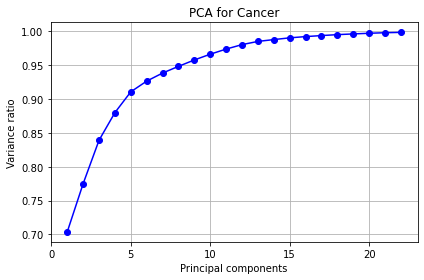

In [4]:
plt.figure()
plt.plot(np.arange(1, dim), er, 'o-', color='b')
plt.xlabel('Principal components')
plt.ylabel('Variance ratio')
plt.title('PCA for Cancer')
plt.grid()
plt.tight_layout()
plt.savefig(fig_path+'pca_var_cancer.png')

In [5]:
comp = 10
pca = PCA(n_components=comp, random_state=id)
pca_result = pca.fit_transform(cancerX_df.values)
for i in range(comp):
    field_name = "pca-"+str(i)
    cancerX_df[field_name] = pca_result[:,i]
    cancer[field_name] = pca_result[:,i]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum(pca.explained_variance_ratio_)
cancerX_pca_10 = pca_result

Explained variation per principal component: [0.53097689 0.1728349  0.07114442 0.06411259 0.04086072 0.03071494
 0.01580837 0.01191472 0.00988429 0.00945446]


In [6]:
cancerX_df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,pca-0,pca-1,pca-2,pca-3,pca-4,pca-5,pca-6,pca-7,pca-8,pca-9
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,1.387021,0.426895,-0.541703,0.048483,-0.072198,0.190817,0.236313,-0.039456,0.077589,0.155297
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.462308,-0.556947,-0.205175,-0.042830,0.016111,0.015604,0.043139,0.020644,-0.070639,-0.085286
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.954621,-0.109701,-0.147848,-0.001068,-0.033798,0.069062,-0.108167,0.007363,-0.059338,-0.073688
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,1.000816,1.525089,-0.053271,-0.207916,-0.219381,0.388007,0.194518,0.143501,0.176992,-0.140949
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.626828,-0.302471,-0.409336,0.238811,-0.002192,-0.157212,-0.063308,0.045930,0.002424,0.000544


In [7]:
rndperm = np.random.permutation(cancer.shape[0])

<AxesSubplot:xlabel='pca-0', ylabel='pca-1'>

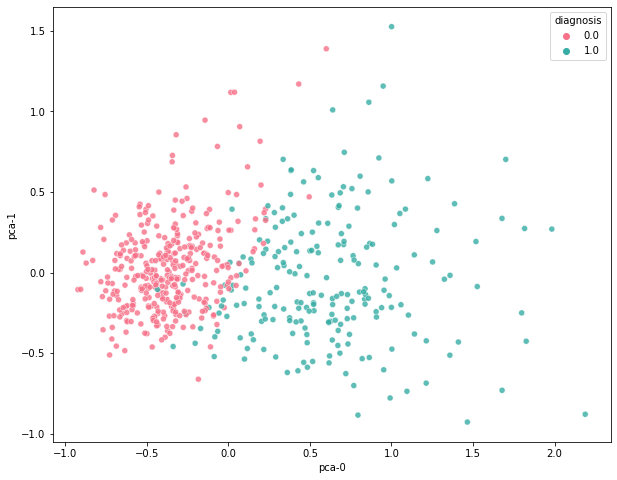

In [8]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="pca-0", y="pca-1",
    hue='diagnosis',
    palette=sns.color_palette("husl", 2),
    data=cancer,
    legend="full",
    alpha=0.8
)

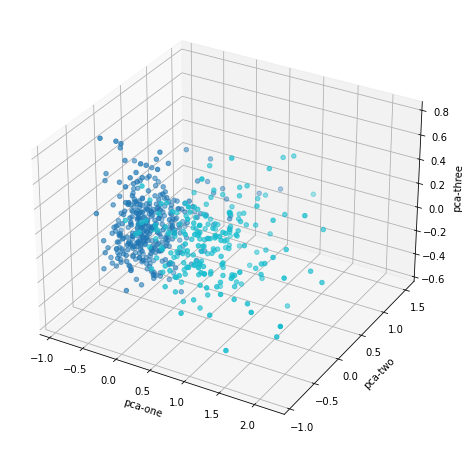

In [9]:
ax = plt.figure(figsize=(10,8)).gca(projection='3d')
ax.scatter(xs=cancer.loc[rndperm, "pca-0"], 
           ys=cancer.loc[rndperm, "pca-1"], 
           zs=cancer.loc[rndperm, "pca-2"], 
           c=cancer.loc[rndperm, "diagnosis"], 
           cmap='tab10')

ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Cancer + PCA + Kmean

In [10]:
clusters = list(range(2,31,1))

In [11]:
cancerX_pca_10.shape

(569, 10)

For n_clusters=2, Silhouette Coeff is 0.4 homogeneity_score is 0.61
For n_clusters=3, Silhouette Coeff is 0.35 homogeneity_score is 0.59
For n_clusters=4, Silhouette Coeff is 0.33 homogeneity_score is 0.66
For n_clusters=5, Silhouette Coeff is 0.18 homogeneity_score is 0.68
For n_clusters=6, Silhouette Coeff is 0.17 homogeneity_score is 0.65
For n_clusters=7, Silhouette Coeff is 0.17 homogeneity_score is 0.72
For n_clusters=8, Silhouette Coeff is 0.17 homogeneity_score is 0.72
For n_clusters=9, Silhouette Coeff is 0.17 homogeneity_score is 0.74
For n_clusters=10, Silhouette Coeff is 0.17 homogeneity_score is 0.77
For n_clusters=11, Silhouette Coeff is 0.17 homogeneity_score is 0.77
For n_clusters=12, Silhouette Coeff is 0.15 homogeneity_score is 0.76
For n_clusters=13, Silhouette Coeff is 0.15 homogeneity_score is 0.76
For n_clusters=14, Silhouette Coeff is 0.13 homogeneity_score is 0.8
For n_clusters=15, Silhouette Coeff is 0.13 homogeneity_score is 0.8
For n_clusters=16, Silhouette C

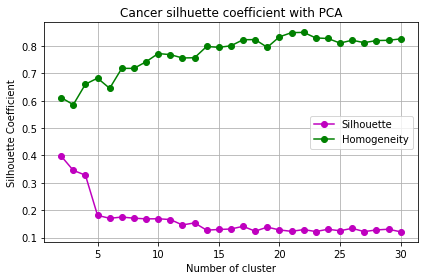

In [12]:
silh = {}
homog = {}
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=500, random_state=id, n_jobs=-1).fit(cancerX_pca_10)
    label = kmeans.labels_
    sil_coeff = silhouette_score(cancerX_pca_10, label, metric='euclidean')
    homog_score = homogeneity_score(cancerY, label)
    silh[cluster] = sil_coeff
    homog[cluster] = homog_score
    print("For n_clusters={}, Silhouette Coeff is {}".format(cluster, round(sil_coeff,2)), "homogeneity_score is {}".format(round(homog_score,2)))
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()), 'o-', color='m', label="Silhouette")
plt.plot(list(homog.keys()), list(homog.values()), 'o-', color='g', label="Homogeneity")
plt.title('Cancer silhuette coefficient with PCA')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(fig_path+'cancer_silhuette_coefficient_pca.png')

# Cancer + PCA + EM

For n_clusters=2, Silhouette Coeff is 0.35 homogeneity_score is 0.48
For n_clusters=3, Silhouette Coeff is 0.27 homogeneity_score is 0.66
For n_clusters=4, Silhouette Coeff is 0.14 homogeneity_score is 0.69
For n_clusters=5, Silhouette Coeff is 0.11 homogeneity_score is 0.78
For n_clusters=6, Silhouette Coeff is 0.11 homogeneity_score is 0.74
For n_clusters=7, Silhouette Coeff is 0.11 homogeneity_score is 0.8
For n_clusters=8, Silhouette Coeff is 0.09 homogeneity_score is 0.74
For n_clusters=9, Silhouette Coeff is 0.1 homogeneity_score is 0.67
For n_clusters=10, Silhouette Coeff is 0.08 homogeneity_score is 0.76
For n_clusters=11, Silhouette Coeff is 0.1 homogeneity_score is 0.76
For n_clusters=12, Silhouette Coeff is 0.1 homogeneity_score is 0.68
For n_clusters=13, Silhouette Coeff is 0.07 homogeneity_score is 0.72
For n_clusters=14, Silhouette Coeff is 0.08 homogeneity_score is 0.73
For n_clusters=15, Silhouette Coeff is 0.07 homogeneity_score is 0.73
For n_clusters=16, Silhouette Co

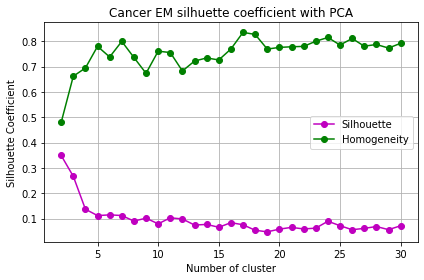

In [13]:
silh_EM = {}
homog_EM = {}
# log_likelihood_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=id, n_init=5).fit(cancerX_pca_10)
    label = gmm.predict(cancerX_pca_10)
    sil_coeff = silhouette_score(cancerX_pca_10, label, metric='euclidean')
    homog_score = homogeneity_score(cancerY, label)
    silh_EM[cluster] = sil_coeff
    homog_EM[cluster] = homog_score
#     log_likelihood_EM[cluster] = gmm.score(cancerX_pca_10)
    print("For n_clusters={}, Silhouette Coeff is {}".format(cluster, round(sil_coeff,2)), "homogeneity_score is {}".format(round(homog_score,2)))
#     print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_EM[cluster]))

    
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()), 'o-', color='m', label="Silhouette")
plt.plot(list(homog_EM.keys()), list(homog_EM.values()), 'o-', color='g', label="Homogeneity")
plt.title('Cancer EM silhuette coefficient with PCA')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(fig_path+'cancer_EM_silhuette_coefficient_pca.png')

# Consumer + PCA

In [14]:
dims_consumer = list(range(1,8,1))

In [15]:
er=[]
for dim in dims_consumer:
    pca = PCA(n_components=dim, random_state=id)
    pca.fit_transform(consumerX_df.values)
    
    # reconstruction
    x_prime = pca.fit_transform(consumerX_df.values)
    A = np.linalg.pinv(pca.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(consumerX_df.values, reconstructed)    
    er.append(sum(pca.explained_variance_ratio_))
    print(dim, ": ", sum(pca.explained_variance_ratio_), rc_err)

1 :  0.42627157452348013 0.07192603997816174
2 :  0.7741047569762419 0.060092898783973045
3 :  0.8514459350139418 0.05746178385298367
4 :  0.8956213370911673 0.05595895492101181
5 :  0.9295937240001616 0.054803228350697133
6 :  0.9571561084916986 0.05386556741496651
7 :  0.9732443769078573 0.05331825116872455


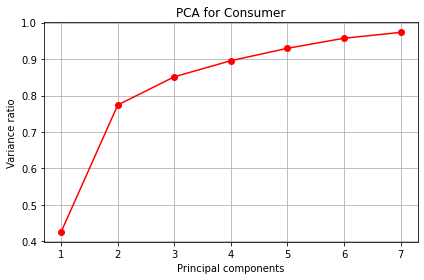

In [16]:
plt.figure()
plt.plot(np.arange(1, dim+1), er, 'o-', color='r')
plt.xlabel('Principal components')
plt.ylabel('Variance ratio')
plt.title('PCA for Consumer')
plt.grid()
plt.tight_layout()
plt.savefig(fig_path+'pca_var_consumer.png')

In [17]:
comp = 6
pca = PCA(n_components=comp, random_state=id)
pca_result = pca.fit_transform(consumerX_df.values)
for i in range(comp):
    field_name = "pca-"+str(i)
    consumerX_df[field_name] = pca_result[:,i]
    consumer[field_name] = pca_result[:,i]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
consumerX_pca_6 = pca_result

Explained variation per principal component: [0.42627157 0.34783318 0.07734118 0.0441754  0.03397239 0.02756238]


In [18]:
rndperm = np.random.permutation(consumer.shape[0])

<AxesSubplot:xlabel='pca-0', ylabel='pca-1'>

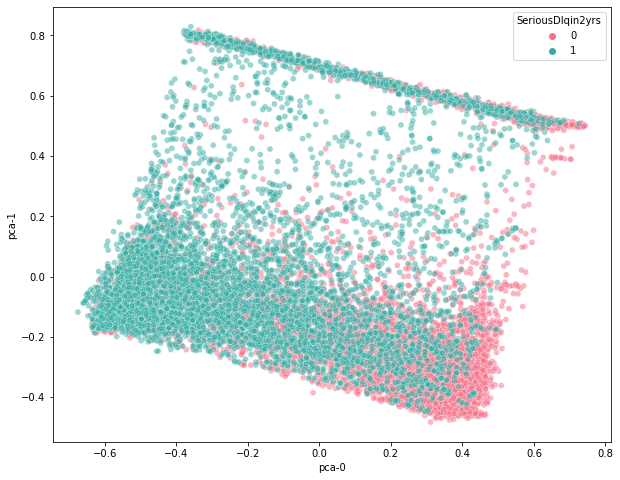

In [19]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="pca-0", y="pca-1",
    hue="SeriousDlqin2yrs",
    palette=sns.color_palette("husl", 2),
    data=consumer,
    legend="full",
    alpha=0.5
)

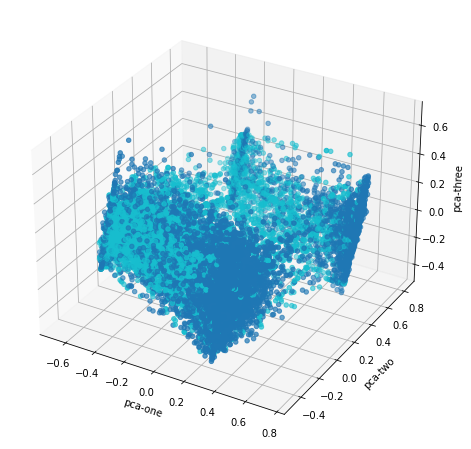

In [20]:
ax = plt.figure(figsize=(10,8)).gca(projection='3d')
ax.scatter(
    xs=consumer.loc[rndperm, "pca-0"], 
    ys=consumer.loc[rndperm, "pca-1"], 
    zs=consumer.loc[rndperm, "pca-2"], 
    c=consumer.loc[rndperm,"SeriousDlqin2yrs"],
    cmap='tab10')

ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Consumer + PCA + Kmean

For n_clusters=2, Silhouette Coeff is 0.34 homogeneity_score is 0.17
For n_clusters=3, Silhouette Coeff is 0.41 homogeneity_score is 0.15
For n_clusters=4, Silhouette Coeff is 0.43 homogeneity_score is 0.17
For n_clusters=5, Silhouette Coeff is 0.32 homogeneity_score is 0.21
For n_clusters=6, Silhouette Coeff is 0.29 homogeneity_score is 0.2
For n_clusters=7, Silhouette Coeff is 0.27 homogeneity_score is 0.21
For n_clusters=8, Silhouette Coeff is 0.27 homogeneity_score is 0.22
For n_clusters=9, Silhouette Coeff is 0.25 homogeneity_score is 0.23
For n_clusters=10, Silhouette Coeff is 0.25 homogeneity_score is 0.23
For n_clusters=11, Silhouette Coeff is 0.23 homogeneity_score is 0.24
For n_clusters=12, Silhouette Coeff is 0.23 homogeneity_score is 0.24
For n_clusters=13, Silhouette Coeff is 0.22 homogeneity_score is 0.24
For n_clusters=14, Silhouette Coeff is 0.22 homogeneity_score is 0.24
For n_clusters=15, Silhouette Coeff is 0.22 homogeneity_score is 0.25
For n_clusters=16, Silhouette

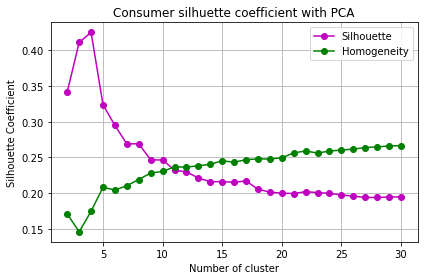

In [21]:
silh_consumer = {}
homog_consumer = {}
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=500, random_state=id, n_jobs=-1).fit(consumerX_pca_6)
    label = kmeans.labels_
    sil_coeff = silhouette_score(consumerX_pca_6, label, metric='euclidean')
    homog_score = homogeneity_score(consumerY, label)
    silh_consumer[cluster] = sil_coeff
    homog_consumer[cluster] = homog_score
    print("For n_clusters={}, Silhouette Coeff is {}".format(cluster, round(sil_coeff,2)), "homogeneity_score is {}".format(round(homog_score,2)))
plt.figure()
plt.plot(list(silh_consumer.keys()), list(silh_consumer.values()), 'o-', color='m', label="Silhouette")
plt.plot(list(homog_consumer.keys()), list(homog_consumer.values()), 'o-', color='g', label="Homogeneity")
plt.title('Consumer silhuette coefficient with PCA')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(fig_path+'consumer_silhuette_coefficient_pca.png')

# Consumer + PCA + EM

For n_clusters=2, Silhouette Coeff is 0.23 homogeneity_score is 0.3
For n_clusters=3, Silhouette Coeff is 0.16 homogeneity_score is 0.25
For n_clusters=4, Silhouette Coeff is 0.12 homogeneity_score is 0.26
For n_clusters=5, Silhouette Coeff is 0.09 homogeneity_score is 0.3
For n_clusters=6, Silhouette Coeff is 0.03 homogeneity_score is 0.29
For n_clusters=7, Silhouette Coeff is -0.02 homogeneity_score is 0.26
For n_clusters=8, Silhouette Coeff is 0.02 homogeneity_score is 0.34
For n_clusters=9, Silhouette Coeff is 0.01 homogeneity_score is 0.33
For n_clusters=10, Silhouette Coeff is 0.0 homogeneity_score is 0.36
For n_clusters=11, Silhouette Coeff is -0.04 homogeneity_score is 0.31
For n_clusters=12, Silhouette Coeff is -0.04 homogeneity_score is 0.37
For n_clusters=13, Silhouette Coeff is -0.07 homogeneity_score is 0.37
For n_clusters=14, Silhouette Coeff is -0.08 homogeneity_score is 0.37
For n_clusters=15, Silhouette Coeff is -0.05 homogeneity_score is 0.38
For n_clusters=16, Silhou

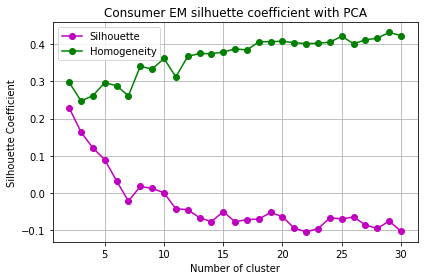

In [22]:
silh_consumer_EM = {}
homog_consumer_EM = {}
# log_likelihood_consumer_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=id, n_init=5).fit(consumerX_pca_6)
    label = gmm.predict(consumerX_pca_6)
    sil_coeff = silhouette_score(consumerX_pca_6, label, metric='euclidean')
    homog_score = homogeneity_score(consumerY, label)
    silh_consumer_EM[cluster] = sil_coeff
    homog_consumer_EM[cluster] = homog_score
#     log_likelihood_consumer_EM[cluster] = gmm.score(consumerX_pca_6)
    print("For n_clusters={}, Silhouette Coeff is {}".format(cluster, round(sil_coeff,2)), "homogeneity_score is {}".format(round(homog_score,2)))
#     print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_consumer_EM[cluster]))
plt.figure()
plt.plot(list(silh_consumer_EM.keys()), list(silh_consumer_EM.values()), 'o-', color='m', label="Silhouette")
plt.plot(list(homog_consumer_EM.keys()), list(homog_consumer_EM.values()), 'o-', color='g', label="Homogeneity")
plt.title('Consumer EM silhuette coefficient with PCA')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(fig_path+'consumer_EM_silhuette_coefficient_pca.png')

## Neural Network + PCA

In [23]:
cancerX_df.shape # this is the dimensionality reduction + clustering

(569, 40)

In [24]:
cancerX_pca_10.shape # this is the dimensionality reduction

(569, 10)

In [25]:
# neural nets with dimensionality reduction only
neural_net = MLPClassifier()
neural_net.fit(cancerX_pca_10, cancerY)

cancer_train_pred = neural_net.predict(cancerX_pca_10)
accuracy = accuracy_score(cancerY, cancer_train_pred)
print('The accuracy score for benchmark is', round(accuracy,4))
print()
print(classification_report(cancerY, cancer_train_pred))

The accuracy score for benchmark is 0.9895

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       357
         1.0       1.00      0.98      0.99       212

    accuracy                           0.99       569
   macro avg       0.99      0.99      0.99       569
weighted avg       0.99      0.99      0.99       569



In [26]:
scores = cross_val_score(neural_net, cancerX_pca_10, cancerY, scoring="f1_weighted", cv=5)
scores, scores.mean()

(array([0.97362143, 0.98236912, 0.98236235, 0.97361643, 0.98238027]),
 0.9788699177323613)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(cancerX_pca_10, cancerY, test_size=0.2, random_state=id)

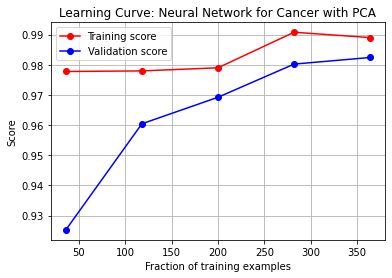

In [28]:
train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(neural_net, X_train, y_train, train_sizes=train_sizes, n_jobs=4, cv=5)

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Validation score')
plt.title('Learning Curve: Neural Network for Cancer with PCA')
plt.xlabel('Fraction of training examples')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path + 'Cancer_nn_PCA_learning_curve.png')

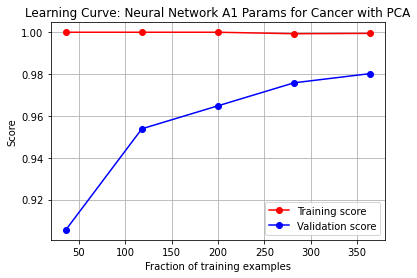

In [29]:
# use parameters from Assignment 1
best_net = MLPClassifier(activation='relu',
                         hidden_layer_sizes=(30,),
                         learning_rate_init=0.01, 
                         max_iter=500,
                         random_state=id, 
                         solver='adam',
                         alpha=0.0001)

train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(best_net, X_train, y_train, train_sizes=train_sizes, n_jobs=4, cv=5)

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Validation score')
plt.title('Learning Curve: Neural Network A1 Params for Cancer with PCA')
plt.xlabel('Fraction of training examples')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path + 'Cancer_nn_A1_params_PCA_learning_curve.png')

In [30]:
# check optimal parameters for nn & pca

param_grid = {'hidden_layer_sizes': [(15,), (15, 7), (30, ), (30, 15)],
              'alpha' : [0.1, 0.01, 0.001],
              'learning_rate': ['constant', 'invscaling', 'adaptive']}

search_f1 = GridSearchCV(MLPClassifier(), param_grid, cv=5, 
                         scoring='accuracy', n_jobs=4)
search_f1.fit(X_train, y_train)
print(search_f1.best_estimator_, search_f1.best_score_)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(15, 7)) 0.989010989010989


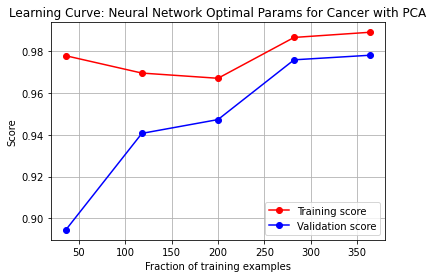

In [31]:
# optimal nn with pca
best_net_PCA = MLPClassifier(activation='relu',
              hidden_layer_sizes=(15, 7), max_iter=500,
              random_state=id, solver='adam', alpha=0.1, learning_rate='adaptive')

train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(best_net_PCA, X_train, y_train, train_sizes=train_sizes, n_jobs=4, cv=5)

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Validation score')
plt.title('Learning Curve: Neural Network Optimal Params for Cancer with PCA')
plt.xlabel('Fraction of training examples')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path + 'Cancer_nn_optimal_params_PCA_learning_curve.png')

In [34]:
best_net_PCA.fit(X_train, y_train)
test_predictions = best_net_PCA.predict(X_test)
print ('classification report + confusion matrix for NN + PCA')
print ()
print(classification_report(y_test, test_predictions, digits=3))
print(confusion_matrix(y_test, test_predictions))

classification report + confusion matrix for NN + PCA

              precision    recall  f1-score   support

         0.0      0.958     0.986     0.972        70
         1.0      0.976     0.932     0.953        44

    accuracy                          0.965       114
   macro avg      0.967     0.959     0.963       114
weighted avg      0.965     0.965     0.965       114

[[69  1]
 [ 3 41]]


# Neural Network + PCA + Kmean

In [34]:
# neural nets with dimensionality reduction & clustering
neural_net = MLPClassifier()
neural_net.fit(cancerX_df, cancerY)

cancer_train_pred = neural_net.predict(cancerX_df)
accuracy = accuracy_score(cancerY, cancer_train_pred)
print('The accuracy score for benchmark is', round(accuracy,4))
print()
print(classification_report(cancerY, cancer_train_pred))

The accuracy score for benchmark is 0.9877

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       357
         1.0       0.99      0.98      0.98       212

    accuracy                           0.99       569
   macro avg       0.99      0.99      0.99       569
weighted avg       0.99      0.99      0.99       569



In [35]:
X_train, X_test, y_train, y_test = train_test_split(cancerX_df, cancerY, test_size=0.2, random_state=id)

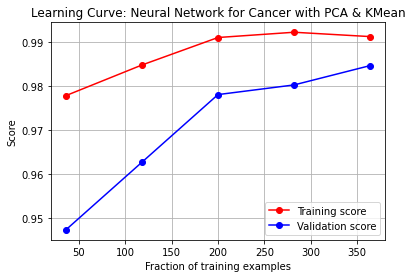

In [36]:
from sklearn.model_selection import learning_curve
train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(neural_net, X_train, y_train, train_sizes=train_sizes, n_jobs=4, cv=5)

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Validation score')
plt.title('Learning Curve: Neural Network for Cancer with PCA & KMean')
plt.xlabel('Fraction of training examples')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path + 'Cancer_nn_PCA_Kmean_learning_curve.png')

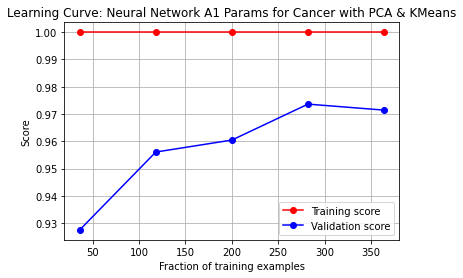

In [37]:
# use parameters from Assignment 1
best_net = MLPClassifier(activation='relu',
                         hidden_layer_sizes=(30,),
                         learning_rate_init=0.01, 
                         max_iter=500,
                         random_state=id, 
                         solver='adam', 
                         alpha=0.0001)

train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(best_net, X_train, y_train, train_sizes=train_sizes, n_jobs=4, cv=5)

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Validation score')
plt.title('Learning Curve: Neural Network A1 Params for Cancer with PCA & KMeans')
plt.xlabel('Fraction of training examples')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path + 'Cancer_nn_A1_params_PCA_Kmean_learning_curve.png')
plt.show()

In [38]:
# check optimal parameters for nn & pca & clustering
param_grid = {'hidden_layer_sizes': [(15,), (15, 7), (30, ), (30, 15)],
              'alpha' : [0.1, 0.01, 0.001],
              'learning_rate': ['constant', 'invscaling', 'adaptive']}

search_f1 = GridSearchCV(MLPClassifier(), param_grid, cv=5, 
                         scoring='accuracy', n_jobs=4)
search_f1.fit(X_train, y_train)

print(search_f1.best_estimator_, search_f1.best_score_)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 15), learning_rate='adaptive') 0.9868131868131869


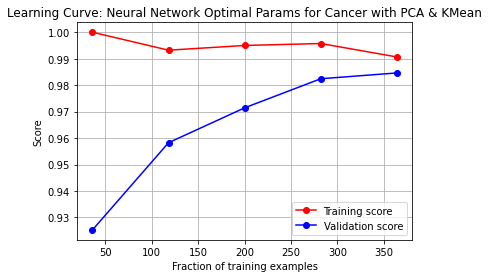

In [39]:
best_net_PCA = MLPClassifier(activation='relu',
                             hidden_layer_sizes=(30, 15), 
                             max_iter=500,
                             random_state=id, 
                             solver='adam', 
                             alpha=0.1, 
                             learning_rate='invscaling')

train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(best_net_PCA, X_train, y_train, train_sizes=train_sizes, n_jobs=4, cv=5)

plt.figure()
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Validation score')
plt.title('Learning Curve: Neural Network Optimal Params for Cancer with PCA & KMean')
plt.xlabel('Fraction of training examples')
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig(fig_path + 'Cancer_nn_optimal_params_PCA_Kmean_learning_curve.png')
plt.show()

In [40]:
best_net_PCA.fit(X_train, y_train)
test_predictions = best_net_PCA.predict(X_test)
print(classification_report(y_test, test_predictions, digits=3))
print(confusion_matrix(y_test, test_predictions))

              precision    recall  f1-score   support

         0.0      0.932     0.986     0.958        70
         1.0      0.975     0.886     0.929        44

    accuracy                          0.947       114
   macro avg      0.954     0.936     0.943       114
weighted avg      0.949     0.947     0.947       114

[[69  1]
 [ 5 39]]
